In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np 
import pyrotd

%matplotlib inline

Create a function for loading AT2 formatted time series.

In [2]:
def load_at2(fpath):
    with open(fpath) as fp:
        for _ in range(3):
            next(fp)
        line = next(fp)
        time_step = float(line[17:25])
        accels = np.array([p for l in fp for p in l.split()]).astype(float)
    return time_step, accels

Load the a pair of rotated time series.

In [3]:
fnames = ['RSN8883_14383980_13849360.AT2', 'RSN8883_14383980_13849090.AT2']
time_series = []
for fname in fnames:
    m = re.search(r'(\d+)(\d{3}).AT2', fname)
    name = '-'.join(m.groups())

    time_step, accels = load_at2(os.path.join('test_data', fname))
    time_series.append({
        'fname': fname,
        'name': name,
        'time_step': time_step,
        'accels': accels,
    })

Compute the response spectra for the individual components

In [4]:
osc_damping = 0.05
osc_freqs = np.logspace(-1, 2, 91)

for ts in time_series:
    ts['spec_accels'] = pyrotd.calc_spec_accels(
        ts['time_step'], ts['accels'], osc_freqs, osc_damping
    )
    

Compute the rotated response spectra

In [7]:
rot_spec_accels = pyrotd.calc_rotated_spec_accels(
    time_series[0]['time_step'], 
    time_series[0]['accels'], time_series[1]['accels'],
    osc_freqs, osc_damping, percentiles=[0, 50, 100],
)

Plot the results

<IPython.core.display.Javascript object>


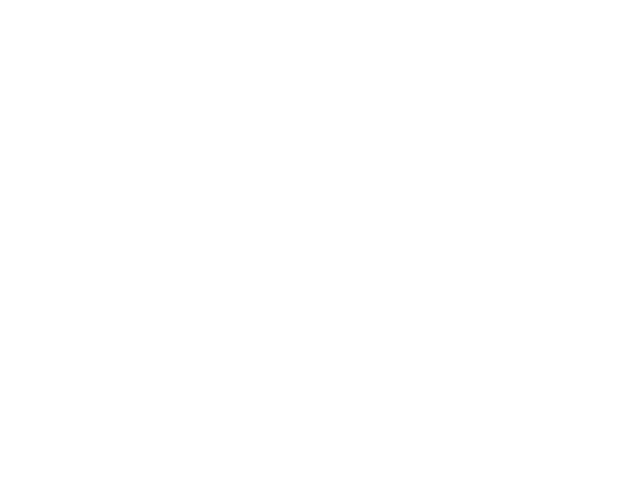

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [7]:
fig, ax = plt.subplots()

for ts in time_series:
    ax.plot(osc_freqs, ts['spec_accels'], linewidth=0.8, label=ts['name'])
    
for p, rsa in zip(percentiles, rot_spec_accels):
    ax.plot(osc_freqs, rsa.value, label='RotD - %d$^{th}$' % p)
    
ax.set(
    xlabel='Frequency (Hz)', xscale='log',
    ylabel='5%-Damped Spectral Accel.', yscale='log',
)
fig.tight_layout()

In [8]:
rot_spec_accels

array([[(   0.,   2.77670363e-04,   89.), (  50.,   6.60801467e-04,   nan),
        ( 100.,   9.30680167e-04,  177.)],
       [(   0.,   3.39672373e-04,   86.), (  50.,   7.71485436e-04,   nan),
        ( 100.,   1.08653311e-03,  177.)],
       [(   0.,   4.04773757e-04,  103.), (  50.,   9.04197606e-04,   nan),
        ( 100.,   1.27349167e-03,  177.)],
       [(   0.,   4.78118963e-04,  104.), (  50.,   1.04552986e-03,   nan),
        ( 100.,   1.47213525e-03,  177.)],
       [(   0.,   5.39197056e-04,  102.), (  50.,   1.21601816e-03,   nan),
        ( 100.,   1.71193980e-03,  177.)],
       [(   0.,   6.49216955e-04,   93.), (  50.,   1.41026489e-03,   nan),
        ( 100.,   1.98506063e-03,  177.)],
       [(   0.,   8.18153344e-04,   80.), (  50.,   1.67312169e-03,   nan),
        ( 100.,   2.35425079e-03,  177.)],
       [(   0.,   1.01442572e-03,   72.), (  50.,   1.97785161e-03,   nan),
        ( 100.,   2.78313242e-03,  177.)],
       [(   0.,   1.10320084e-03,   92.), (  50.